In [1]:
# imports
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import glob
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# loading datasets
base_path = '/home/fali/Documents/CarND-Vehicle-Detection-master/examples/'
non_cars = [] 
non_cars.extend(glob.glob(base_path+'non-vehicles/Extras/*.png'))
non_cars.extend(glob.glob(base_path+'non-vehicles/GTI/*.png'))

cars = [] 
cars.extend(glob.glob(base_path+'vehicles/GTI_Far/*.png'))
cars.extend(glob.glob(base_path+'vehicles/GTI_Left/*.png'))
cars.extend(glob.glob(base_path+'vehicles/GTI_MiddleClose/*.png'))
cars.extend(glob.glob(base_path+'vehicles/GTI_Right/*.png'))
cars.extend(glob.glob(base_path+'vehicles/KITTI_extracted/*.png'))
print("Number of examples of cars: ", len(cars), ", and non-cars: ", len(non_cars))

Number of examples of cars:  8792 , and non-cars:  8968


The dataset contains  8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


Text(0.5,1,'Example not-car image')

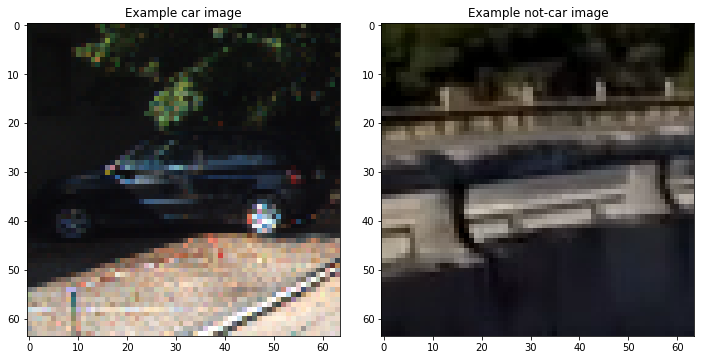

In [3]:
# a function to return some characteristics of the dataset

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, non_cars)
print('The dataset contains ', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(non_cars))
    
# Read in car / not-car images
car_image = plt.imread(cars[car_ind])
notcar_image = plt.imread(non_cars[notcar_ind])

# Plot the examples
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
f.tight_layout()
ax1.imshow(car_image)
ax1.set_title('Example car image')
ax2.imshow(notcar_image)
ax2.set_title('Example not-car image')

In [4]:
# a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# a function to extract features from a list of images
def extract_hog_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for filee in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(filee)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


    
# a function that takes an image, 
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# and returns list of windows
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

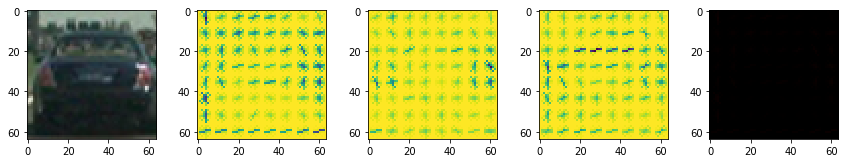

In [5]:
# visualise HOG features for different color spaces
car_imgg_ori = mpimg.imread(cars[2000])
color = cv2.COLOR_RGB2YCrCb
car_imgg = cv2.cvtColor(car_imgg_ori, color)

_,temp_img_ch0 = get_hog_features(car_imgg[:,:,0], 9, 8, 2, vis = True, feature_vec=False)
_,temp_img_ch1 = get_hog_features(car_imgg[:,:,1], 9, 8, 2, vis = True, feature_vec=False)
_,temp_img_ch2 = get_hog_features(car_imgg[:,:,2], 9, 8, 2, vis = True, feature_vec=False)

all_3_channels = np.dstack((temp_img_ch0, temp_img_ch1, temp_img_ch2))

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(12, 4))
f.tight_layout()
ax1.imshow(car_imgg_ori)
ax2.imshow(1-temp_img_ch0)
ax3.imshow(1-temp_img_ch1)
ax4.imshow(1-temp_img_ch2)
ax5.imshow(all_3_channels)

In [6]:
# a function to extract features for a given window
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            print(feature_image[:,:,1].min(), feature_image[:,:,1].max())
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [7]:
# a function to classify contents of each window as car or non car.
# for speed, the function calculates hog features in the beginning, then 
# subsampled from an array that contains features for the whole image.
def search_windows_fast(input_img, windows, clf, scaler, color_space='RGB', 
                    orient=9, pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0,y_start=360):
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            img = cv2.cvtColor(input_img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            img = cv2.cvtColor(input_img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            img = cv2.cvtColor(input_img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            img = cv2.cvtColor(input_img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            img = cv2.cvtColor(input_img, cv2.COLOR_RGB2YCrCb)
    else: 
        img = np.copy(input_img)   
    
    if hog_channel == 'ALL':
        feature_array = []
        for channel in range(img.shape[2]):
            feature_array.append(hog(img[y_start:,:,channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=False, feature_vector=False) )
            
    else:
        feature_array = hog(img[y_start:,:,hog_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=False, feature_vector=False)

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        #win[0][1], win[1][1], win[0][0],win[1][0]
        st_y = int((window[0][1]-y_start)/float(pix_per_cell))
        en_y = int((window[1][1]-y_start)/float(pix_per_cell))-(cell_per_block-1)
        st_x = int(window[0][0]/float(pix_per_cell))
        en_x = int(window[1][0]/float(pix_per_cell))-(cell_per_block-1)
        
        #4) Extract features for that window using the subsample
        if hog_channel == 'ALL':
            features = np.array([])
            for channel in range(img.shape[2]):
                sub_sampled_feature_array = feature_array[channel][st_y:en_y,st_x:en_x, :, :, :]
                features = np.concatenate((features,np.ravel(sub_sampled_feature_array)))
        else:
            sub_sampled_feature_array = feature_array[st_y:en_y,st_x:en_x, :, :, :]
            features = np.ravel(sub_sampled_feature_array)    
            
        #time to do prediction
        #ignore windows for which extracted features don't match size of training data (1794*3 for 3 Channel HOG features)
        if len(features) == X.shape[1]:
            #5) Scale extracted features to be fed to classifier
            #print(features.shape)
            test_features = scaler.transform(features.reshape(1, -1))
            #6) Predict using your classifier
            prediction = clf.predict(test_features)
            #print prediction
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                #print 'yes'
                on_windows.append(window)

    return on_windows

In [8]:
# create and train classifier
spatial_size = (34, 34) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram featextract_featuresures on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, None] # Min and max in y to search in slide_window()

color_space = 'YCrCb'
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

car_features = extract_hog_features(cars, color_space=color_space, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

notcar_features = extract_hog_features(non_cars, color_space=color_space, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
#print(X)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
18.56 Seconds to train SVC...
Test Accuracy of SVC =  0.982


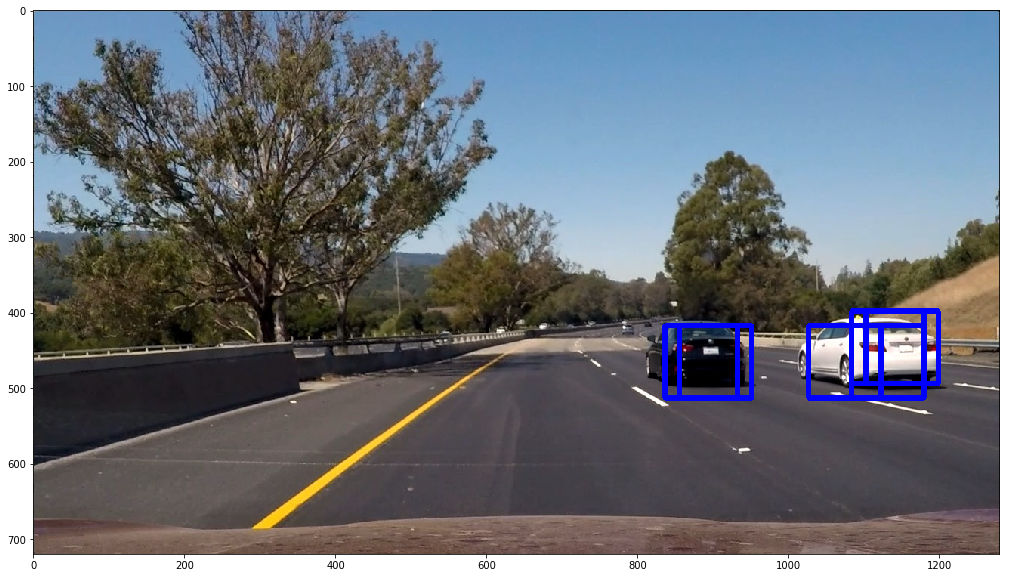

In [9]:
# try on a test image

image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)

image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.80, 0.80))   


hot_windows = search_windows_fast(image, windows, svc, X_scaler, color_space=color_space, 
                         orient=orient, pix_per_cell=int(pix_per_cell*3/2), 
                         cell_per_block=cell_per_block, 
                         hog_channel=hog_channel, y_start = y_start_stop[0]) 



window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    


plt.figure(figsize=(50,10))
plt.imshow(window_img, interpolation='nearest')

In [10]:
# functions that deal with false positives

# a function that adds +1 for each bounding box that passes through 
# the current pixel
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# a function that rejects areas where few boxes have been present
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# a function that draws boxes according to the heat map
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [11]:
previous_boxes = []
# a function which applies sliding window classifier to an image in order
# to detect cars in it
def process_image(image):

    draw_image = np.copy(image)
    
    image = image.astype(np.float32)/255
    
    
    y_start_stop = [360, None] # Min and max in y to search in slide_window()


    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.80, 0.80))
    
    
   
    hot_windows1 = search_windows_fast(image, windows1, svc, X_scaler, color_space=color_space, 
                           orient=orient, pix_per_cell=int(pix_per_cell*3/2), 
                           cell_per_block=cell_per_block, 
                           hog_channel=hog_channel, y_start = y_start_stop[0])
    
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.80, 0.80))
    
    
   
    hot_windows2 = search_windows_fast(image, windows2, svc, X_scaler, color_space=color_space, 
                           orient=orient, pix_per_cell=pix_per_cell, 
                           cell_per_block=cell_per_block, 
                           hog_channel=hog_channel, y_start = y_start_stop[0])
   
    hot_windows = hot_windows1 + hot_windows2
    
    history = 25
    previous_boxes.append(hot_windows)
    if len(previous_boxes) >= history:
        heatmap = np.zeros_like(draw_image).astype(np.uint8)
        for i in range(history):
               add_heat(heatmap, previous_boxes[-i]) 
        temp_img = apply_threshold(heatmap, 20)
        labels = label(temp_img)
        window_img = draw_labeled_bboxes(draw_image, labels)
    else:
        window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  
    
    return window_img

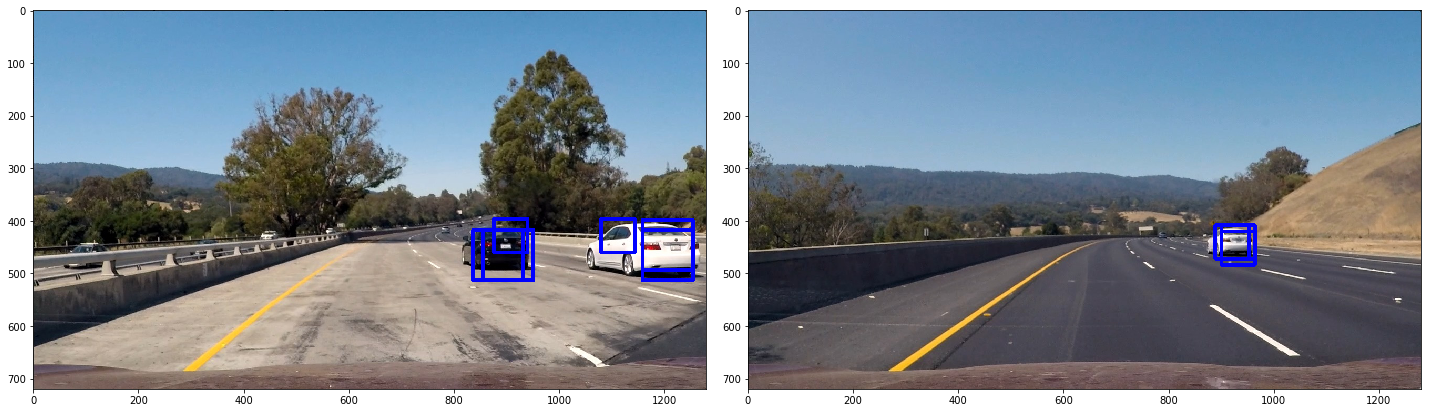

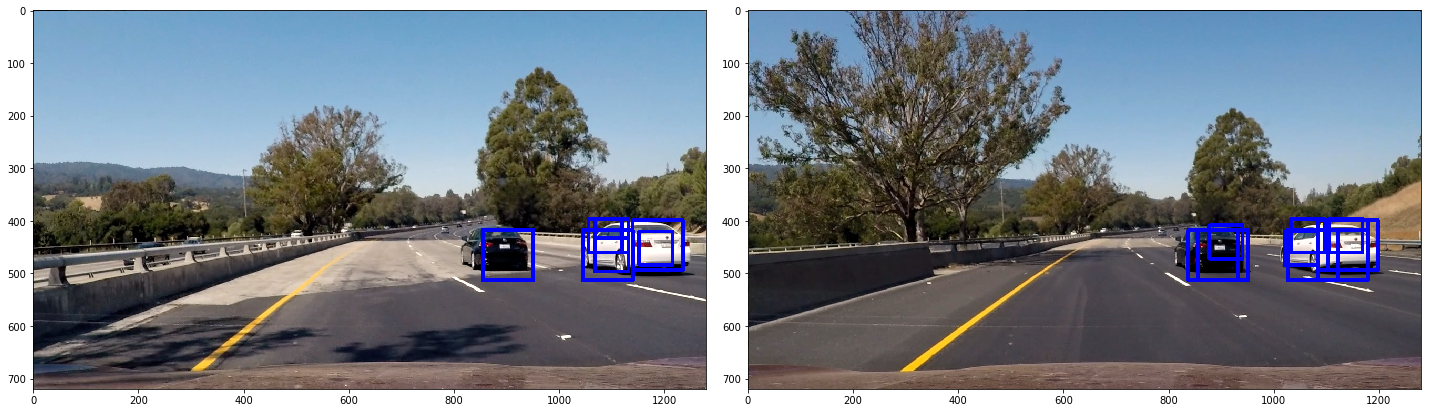

In [12]:
names = []
for i in range (1, 7):
    names.append('test_images/test' + str(i) + '.jpg')
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 20))
f1.tight_layout()
f2.tight_layout()
previous_boxes = []
image1 = mpimg.imread(names[0])
image2 = mpimg.imread(names[2])
image3 = mpimg.imread(names[3])
image4 = mpimg.imread(names[5])
ax1.imshow(process_image(image1))
ax2.imshow(process_image(image2))
ax3.imshow(process_image(image3))
ax4.imshow(process_image(image4))

In [13]:
previous_boxes = []
# a function which applies sliding window classifier to an image in order
# to detect cars in it
def show_heat(image):

    draw_image = np.copy(image)
    
    image = image.astype(np.float32)/255
    
    
    y_start_stop = [360, None] # Min and max in y to search in slide_window()


    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.80, 0.80))
    
    
   
    hot_windows1 = search_windows_fast(image, windows1, svc, X_scaler, color_space=color_space, 
                           orient=orient, pix_per_cell=int(pix_per_cell*3/2), 
                           cell_per_block=cell_per_block, 
                           hog_channel=hog_channel, y_start = y_start_stop[0])
    
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.80, 0.80))
    
    
   
    hot_windows2 = search_windows_fast(image, windows2, svc, X_scaler, color_space=color_space, 
                           orient=orient, pix_per_cell=pix_per_cell, 
                           cell_per_block=cell_per_block, 
                           hog_channel=hog_channel, y_start = y_start_stop[0])
   
    hot_windows = hot_windows1 + hot_windows2
    
    history = 25
    previous_boxes.append(hot_windows)
    
    heatmap = np.zeros_like(draw_image).astype(np.uint8)

    add_heat(heatmap, hot_windows) 
  
    
    return heatmap*30

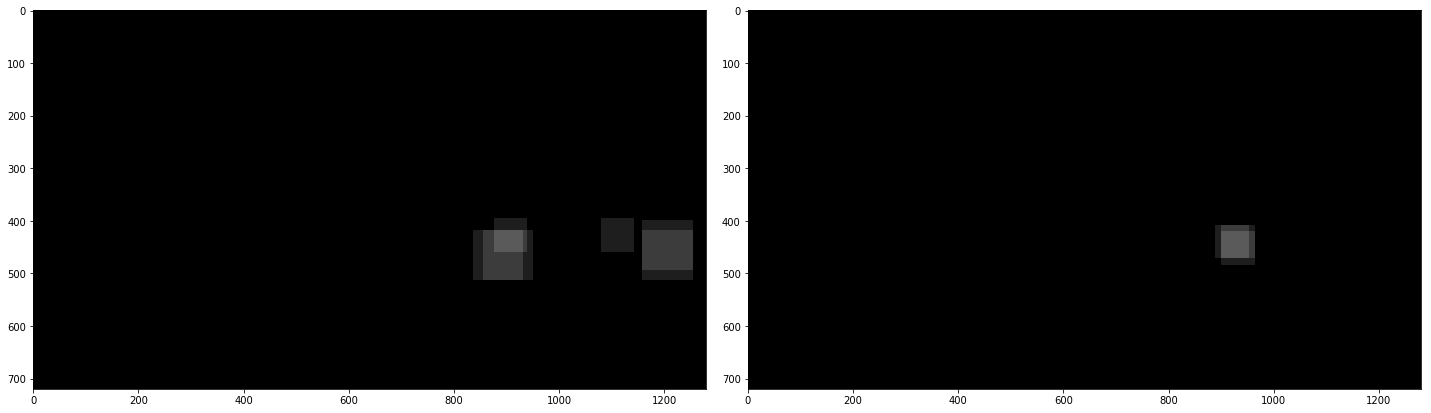

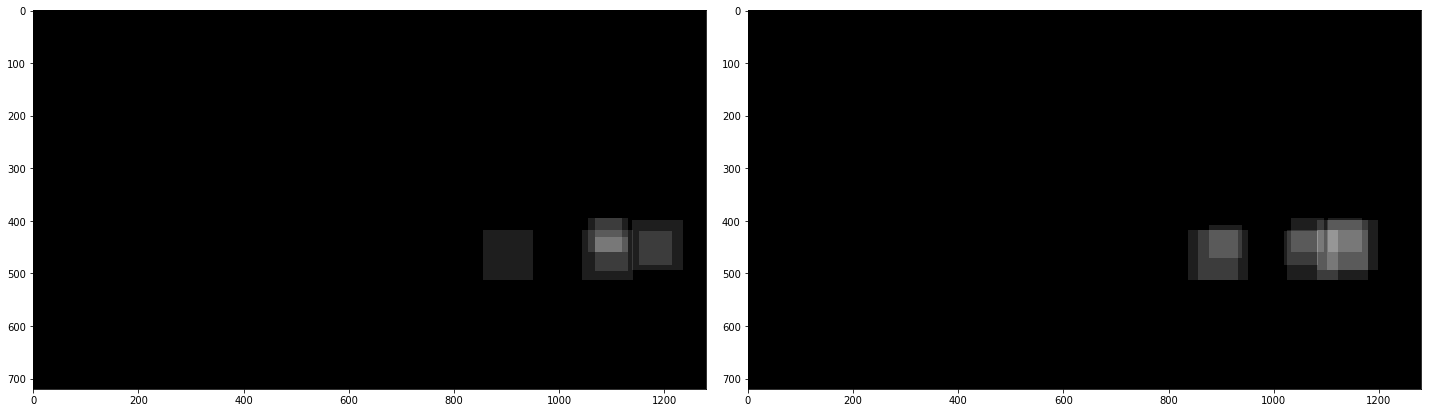

In [14]:
names = []
for i in range (1, 7):
    names.append('test_images/test' + str(i) + '.jpg')
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 20))
f1.tight_layout()
f2.tight_layout()
previous_boxes = []
image1 = mpimg.imread(names[0])
image2 = mpimg.imread(names[2])
image3 = mpimg.imread(names[3])
image4 = mpimg.imread(names[5])
ax1.imshow(show_heat(image1))
ax2.imshow(show_heat(image2))
ax3.imshow(show_heat(image3))
ax4.imshow(show_heat(image4))

In [15]:
previous_boxes = []
# a function to demonstrate output of process_image function when applied to video
def show_output(image):

    draw_image = np.copy(image)
    
    image = image.astype(np.float32)/255
    
    
    y_start_stop = [360, None] # Min and max in y to search in slide_window()


    windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.80, 0.80))
    
    
   
    hot_windows1 = search_windows_fast(image, windows1, svc, X_scaler, color_space=color_space, 
                           orient=orient, pix_per_cell=int(pix_per_cell*3/2), 
                           cell_per_block=cell_per_block, 
                           hog_channel=hog_channel, y_start = y_start_stop[0])
    
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.80, 0.80))
    
    
   
    hot_windows2 = search_windows_fast(image, windows2, svc, X_scaler, color_space=color_space, 
                           orient=orient, pix_per_cell=pix_per_cell, 
                           cell_per_block=cell_per_block, 
                           hog_channel=hog_channel, y_start = y_start_stop[0])
   
    hot_windows = hot_windows1 + hot_windows2
    history = 25

    heatmap = np.zeros_like(draw_image).astype(np.uint8)
    add_heat(heatmap, hot_windows) 
    temp_img = apply_threshold(heatmap, 1)
    labels = label(temp_img)
    window_img = draw_labeled_bboxes(draw_image, labels)
  
    
    return window_img

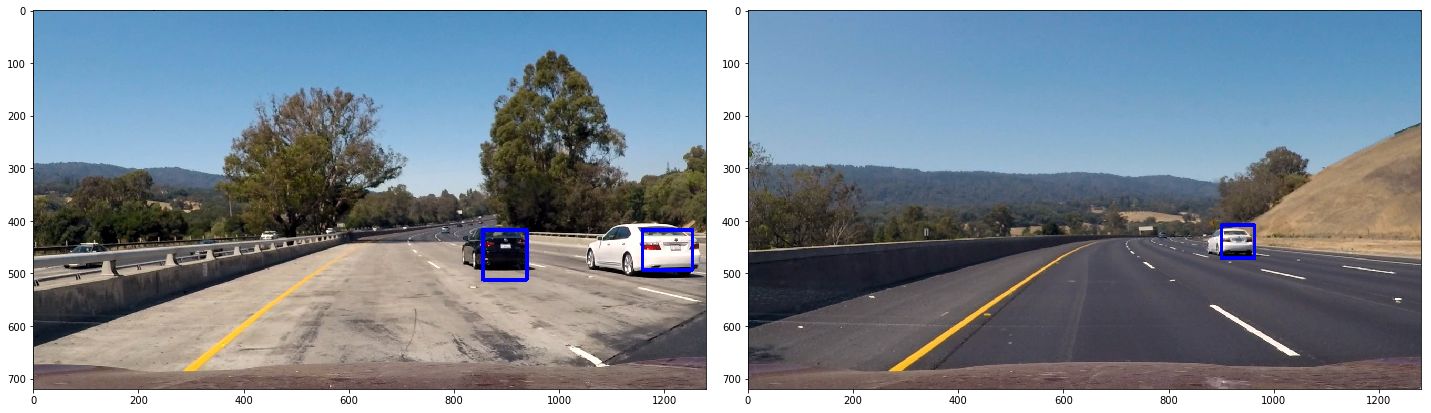

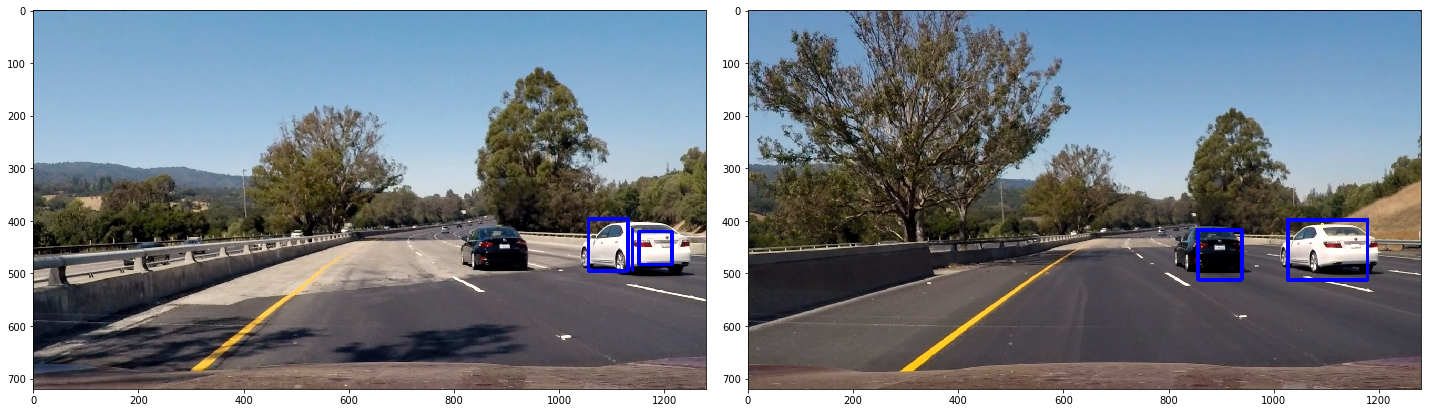

In [16]:
names = []
for i in range (1, 7):
    names.append('test_images/test' + str(i) + '.jpg')
f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
f2, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 20))
f1.tight_layout()
f2.tight_layout()
previous_boxes = []
image1 = mpimg.imread(names[0])
image2 = mpimg.imread(names[2])
image3 = mpimg.imread(names[3])
image4 = mpimg.imread(names[5])
ax1.imshow(show_output(image1))
ax2.imshow(show_output(image2))
ax3.imshow(show_output(image3))
ax4.imshow(show_output(image4))

In [17]:
# process video
project_video_out = 'project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
test_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time test_clip.write_videofile(project_video_out, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [37:29<00:01,  1.79s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 36min 30s, sys: 40.1 s, total: 37min 10s
Wall time: 37min 30s
